# Six Assumptions of Linear Regression

A1. $\epsilon_1$, $\epsilon_2$, ..., $\epsilon_n$ have zero mean.

A2. $\epsilon_1$, $\epsilon_2$, ..., $\epsilon_n$ are normally distributed.

A3. $\epsilon_1$, $\epsilon_2$, ..., $\epsilon_n$ are indepedent.

A4. $\epsilon_1$, $\epsilon_2$, ..., $\epsilon_n$ have a common unknown variance $\sigma^2$.

A5. There is no linear relationship among the explanatory variables, i.e., there is no multicollinearity

A6.  Linearity: The true relationship between the mean of the response variable

<center>
E[Y]= $\beta_0$ + $\beta_1 x_1$  + $\beta_2 x_2$ + ... +  + $\beta_k x_k$
</center>
    
and the explanatory variables $x_1$, $x_1$, ... , $x_k$ is linear.

# Part I. Assumptions Tests

First, take a look at the dataset.

In [302]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_csv('hprice.txt', sep='\t')
df = df[['Y', 'X1', 'X2', 'X3', 'X4']]
patsy_formula = 'y ~ x1 + x2 + x3 + x4'
data = pd.DataFrame({'x1': df['X1'], 'x2': df['X2'], 'x3': df['X3'], 'x4': df['X4'], 'y': df['Y']})
model = smf.ols(formula = patsy_formula, data = data).fit()
extresid = model.get_influence().resid_studentized_external
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     156.0
Date:                Sun, 28 Mar 2021   Prob (F-statistic):           1.18e-88
Time:                        14:59:42   Log-Likelihood:                -6130.0
No. Observations:                 546   AIC:                         1.227e+04
Df Residuals:                     541   BIC:                         1.229e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4009.5500   3603.109     -1.113      0.266   -1.11e+04    3068.248
x1             5.4292      0.369     14.703      0.000       4.704       6.155
x2          2824.6138   1214.808      2.325      0.020     438.296    5210.932
x3          1.711e+04   1734.434      9.862      0.000    1.37e+04    2.05e+04
x4          7634.8970   1007.974      7.574      0.000    5654.874    9614.920
==============================================================================
Omnibus:                       94.915   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.320
Skew:                           0.893   Prob(JB):                     3.57e-51
Kurtosis:                       5.650   Cond. No.                     2.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Student's T-test (Checking A1: Zero Mean)

In [303]:
import scipy as sp

confidence_level = 0.95
significance_level = 1 - confidence_level
population_mean = 0
stat, p_value = sp.stats.ttest_1samp(a=extresid, popmean=population_mean)
print(f'p == {p_value:.6f}', end='')
if p_value > significance_level:
    print(f' (p > {significance_level:.2f}), sample mean equal to {population_mean} (fail to reject H0)')
else:
    print(f' (P <= {significance_level:.2f}), sample mean does NOT equal to {population_mean} (reject H0)')   

p == 0.992227 (p > 0.05), sample mean equal to 0 (fail to reject H0)


## Q-Q Plot (Checking A2: Normally Distributed)

If the data is normally distributed, the points in the QQ-normal plot lie on a straight diagonal line. However, more often than not, many cases are not that clear-cut just like the following one.

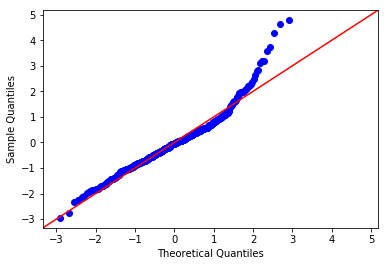

In [304]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
    
sm.qqplot(extresid, line='45')
plt.show()

## Normality Tests (Checking A2: Normally Distributed)

#### Shapiro–Wilk test

In [305]:
from scipy.stats import shapiro

assert len(extresid) >= 3 and len(extresid) <= 5000
assert np.isnan(extresid).any() == False
'''
WARNING: According to page 228 of lecture-2-3_Ch1_MFIT5003_Fall2020-21_with_MJD.pdf,
the allowed dataset length for Shapiro-Wilk test is [3, 5000]
'''
confidence_level = 0.95
significance_level = 1 - confidence_level
stat, p_value = shapiro(extresid)
print(f'p == {p_value:.6f}', end='')
if p_value > significance_level:
    print(f' (p > {significance_level:.2f}), sample looks Gaussian (fail to reject H0)')
else:
    print(f' (P <= {significance_level:.2f}), sample does NOT look Gaussian (reject H0)')    

p == 0.000000 (P <= 0.05), sample does NOT look Gaussian (reject H0)


 #### Kolmogorov-Smirnov test (KS test)

In [306]:
from scipy.stats import kstest

extresid = (extresid - np.mean(extresid))/np.std(extresid)
# dataset will be STANDARDIZED before conducting kstest.'

confidence_level = 0.95
significance_level = 1 - confidence_level
stat, p_value = kstest(extresid, cdf = 'norm')
print(f'p == {p_value:.6f}', end='')
if p_value > significance_level:
    print(f' (p > {significance_level:.2f}), sample looks Gaussian (fail to reject H0)')
else:
    print(f' (P <= {significance_level:.2f}), sample does NOT look Gaussian (reject H0)') 

p == 0.002132 (P <= 0.05), sample does NOT look Gaussian (reject H0)


## Scatter Plot (Checking A3: Independent)

We tested normality above. No autocorrelation + normality means independence. In the following, we plot $\epsilon_i$ against $\epsilon_{i-1}$. If you observe no patterns then it is likely that the no-autocorelation assumption is met then we draw the conclusion that error terms are independent.

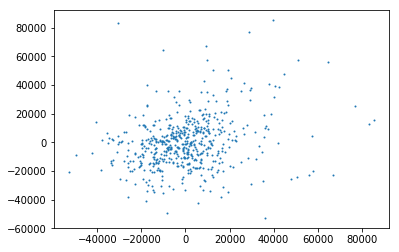

In [307]:
et = model.resid
et_1 = et.shift(1)

plt.scatter(x=et_1[1:], y=et[1:], s = 1)
plt.show()

## Durbin–Watson statistic (Checking A3: Independent)

The Durbin–Watson statistic is a test statistic used to detect the presence of autocorrelation at lag 1 in the residuals (prediction errors) from a regression analysis:

DW $\approx$ 0: we can say that there is a strong positive autocorrelation;

DW $\approx$ 2: we can say that there is no autocorrelation ;

DW $\approx$ 4: we can say that there is a strong negative autocorrelation.

In [308]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(model.resid.values)
print(f'Durbin-Watson statistic: {dw:.5f}', end = '')
if 2.5 <= dw <= 4:
    print(', implying a STRONG negative autocorrelation')
elif 1.5 < dw < 2.5:
    print(', implying no significant autocorrelation')
elif 0 <= dw <= 1.5:
    print(', implying a STRONG positive autocorrelation')
else:
    print(', This is IMPOSSIBLE!!!')

Durbin-Watson statistic: 1.48294, implying a STRONG positive autocorrelation


## Externally Studentized Residual Plots (Checking A1 to A4 and A6)

1. If you observe pattern (a), i.e., there is no noticeable pattern, the points are around zero and most of them are inside the band |$r_i$| ≤ 2, then we can say that A1 to A4 are likely met;
2. If you observe pattern (b), it means that the variance of error increases when $\hat{y}$ increase; 
3. If you observe pattern (c), it means that the variance of error decreases when $\hat{y}$ increase;
4. If you observe pattern (d), it means that the variance is relatively small for smaller and larger values of $\hat{y}$, but relatively large for the moderate values of $\hat{y}$.
5. If you observe patterns (e) or (f), it suggest that the regression model may be nonlinear or we may miss one or more significant terms.

<img src="esr.png" alt="externally-studentized-residual-plot" style="width: 300px;"/>

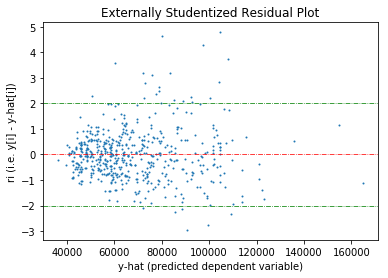

In [309]:
import matplotlib.pyplot as plt
extresid = model.get_influence().resid_studentized_external
pred = model.predict()

plt.scatter(pred, extresid, s = 1)
plt.xlabel('y-hat (predicted dependent variable)')
plt.ylabel('ri (i.e. y[i] - y-hat[i])')
plt.axhline(y=2, color='g', linestyle='-.', linewidth = 0.75)
plt.axhline(y=0, color='r', linestyle='-.', linewidth = 0.75)
plt.axhline(y=-2, color='g', linestyle='-.', linewidth = 0.75)
plt.title('Externally Studentized Residual Plot')
plt.show()

## T-Test for sample mean (Checking A1: Zero Mean)

## Pearson's correlation coefficient (Checking A5: Multicollinearity)

Pearson's correlation matrix could help. However, among all explanatory variables it ONLY shows the association between any two variables, ignoring other explanatory variables. However, the multicollinearity involves associations among all explanatory variables.

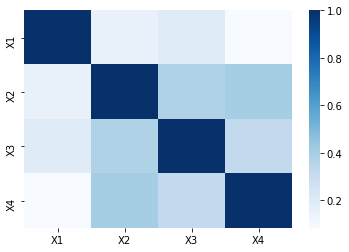

In [310]:
import seaborn as sns

corr = df[['X1', 'X2', 'X3', 'X4']].corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Blues)

## Variance Inflation Factor (Checking A5: Multicollinearity)

Compared with correlation coefficient, VIF is a more proper way to detect multicollinearity. It provides an index that measures how much the variance of an estimated regression coefficient is increased because of collinearity.

In [311]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['X1', 'X2', 'X3', 'X4']]
X['constant'] = 1 # add a constant as the intercept
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    print(f'[{X.columns[i]}] vif == {vif:.5f}: ', end = '')
    if vif > 10:
    # 10: An indication that multicollinearity may be present
    # 100: Certain multicollinearity among the variables
        print('multicollinearity is SERIOUS')
    else:
        print('multicollinearity is NOT that serious')

[X1] vif == 1.04705: multicollinearity is NOT that serious
[X2] vif == 1.31085: multicollinearity is NOT that serious
[X3] vif == 1.23920: multicollinearity is NOT that serious
[X4] vif == 1.25109: multicollinearity is NOT that serious
[constant] vif == 21.24698: multicollinearity is SERIOUS


## Component-Component Plus Residual Plot (Checking A6: Linear)

If the partial residual plot for $X_j$ shows a straight line, it is an indication that the true relationship between the response variable Y and $X_j$ is straight-line, when all other variables are taken into account. If the plot shows a non-linear relationship , it is an indication that $X_j$ (partially) affects $y$ in a non-linear fashion.

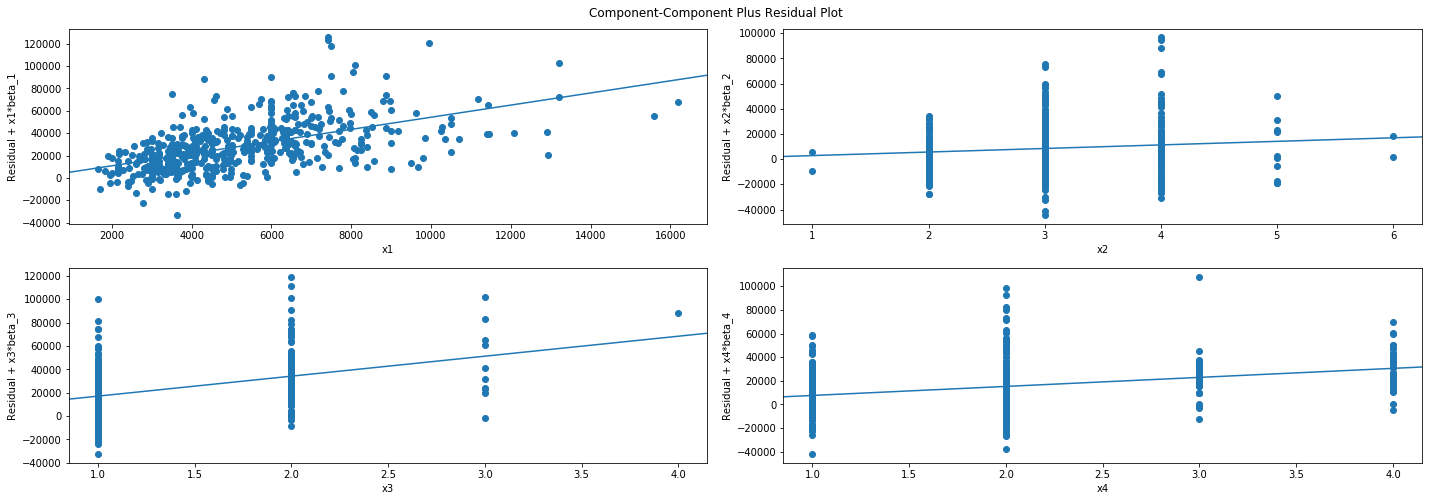

In [312]:
fig1 = plt.figure(figsize=(20, 10))
sm.graphics.plot_ccpr_grid(model, fig=fig1)
plt.show()

# Part II. Remedies

This part is still under developing...I will push the latest version from time to time.

Thanks!

## Box-Cox Transformation
### Pre-Transformation

In [313]:
df = pd.read_csv('diamond.txt', sep='\s+')
df['cbrt_carat'] = df['carat'] ** (1 / 3)

model = smf.ols(formula = 'price ~ colorscore + clarityscore + cutscore + cbrt_carat',
                data = df[['price', 'colorscore', 'clarityscore', 'cutscore', 'cbrt_carat']]).fit()
# This formula is given as domain knowledge
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     137.8
Date:                Sun, 28 Mar 2021   Prob (F-statistic):           2.01e-40
Time:                        14:59:44   Log-Likelihood:                -918.40
No. Observations:                 108   AIC:                             1847.
Df Residuals:                     103   BIC:                             1860.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.783e+04   1173.047    -15.196      0.000   -2.02e+04   -1.55e+04
colorscore     262.8814     80.759      3.255      0.002     102.715     423.048
clarityscore   561.3754     81.822      6.861      0.000     399.101     723.650
cutscore        68.7845    110.716      0.621      0.536    -150.794     288.363
cbrt_carat    2.001e+04    868.733     23.031      0.000    1.83e+04    2.17e+04
==============================================================================
Omnibus:                       44.472   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.626
Skew:                           1.481   Prob(JB):                     1.17e-28
Kurtosis:                       7.451   Cond. No.                         91.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

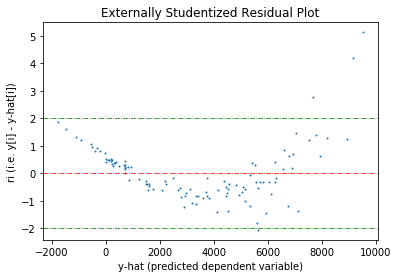

In [314]:
import matplotlib.pyplot as plt
extresid = model.get_influence().resid_studentized_external
pred = model.predict()

plt.scatter(pred, extresid, s = 1)
plt.xlabel('y-hat (predicted dependent variable)')
plt.ylabel('ri (i.e. y[i] - y-hat[i])')
plt.axhline(y=2, color='g', linestyle='-.', linewidth = 0.75)
plt.axhline(y=0, color='r', linestyle='-.', linewidth = 0.75)
plt.axhline(y=-2, color='g', linestyle='-.', linewidth = 0.75)
plt.title('Externally Studentized Residual Plot')
plt.show()

The externally studentized residual plot implies non-constant variance

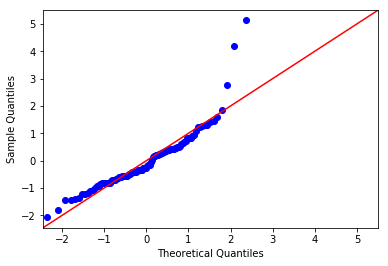

In [315]:
import statsmodels.api as sm
    
sm.qqplot(extresid, line='45')
plt.show()

Q-Q plot indicates violation of normal distribution assumption

### Transformation

In [316]:
def box_cox_transformer(lambda1: float, X: np.ndarray, y: np.ndarray):

    if lambda1 != 0:
        BCy = (y ** lambda1 - 1) / lambda1
    else:
        BCy = np.log(y)
    
    BCfmodel = smf.ols(formula = 'BCy ~ x', data = {'BCy': BCy, 'x': X}).fit()

    SSE_lambda = ((BCfmodel.predict() - BCy) ** 2).sum()

    loglf = (lambda1 - 1) * ((np.log(y)).sum()) - len(y) * (np.log(SSE_lambda / len(y))) / 2

    return { 'lambda': lambda1, 'loglf': loglf }

def box_cox_transform_inverse(yt, lambda1=0):
# http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html#3_transformation_and_back-transformation

    assert lambda1 != 0 # Not implemented
    return np.exp(np.log(1 + lambda1 * yt) / lambda1)

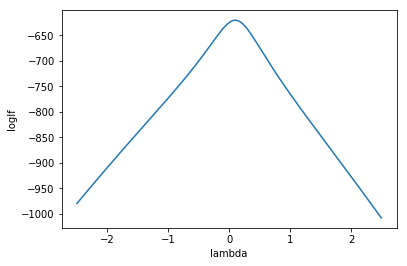

lambda_fit: 0.09999999999994458


,index,colorscore,clarityscore,cutscore,carat,price,cbrt_carat,price_transformed
0,1,7,6,4,0.33,1002,0.691042,9.956610
1,2,6,3,2,1.01,4986,1.003322,13.430159
2,3,7,3,4,1.01,5644,1.003322,13.722404
3,4,7,3,5,0.34,626,0.697953,9.039583
4,5,3,2,4,1.00,4032,1.000000,12.937815
...,...,...,...,...,...,...,...,...
103,104,2,1,2,1.03,2540,1.009902,11.901980
104,105,3,3,5,1.29,7513,1.088587,14.410762
105,106,7,5,5,0.31,877,0.676790,9.692459
106,107,7,6,4,0.72,3459,0.896281,12.588899


In [317]:
y = df['price']
X = df[['colorscore', 'clarityscore', 'cutscore', 'cbrt_carat']]

BC = pd.DataFrame(columns = ['lambda', 'loglf'])
lambda1 = np.arange(-2.5, 2.5, 0.01)

for i in range(1, len(lambda1)):
    BC.loc[i] = box_cox_transformer(lambda1=lambda1[i], X=X, y=y)

sns.lineplot(data=BC, x='lambda', y= 'loglf')
plt.show()

lambda_fit = BC['lambda'][BC['loglf'] == BC['loglf'].max()].values[0]
print(f'lambda_fit: {lambda_fit}')

BCy = (y ** lambda_fit - 1) / lambda_fit

df['price_transformed'] = BCy
df

In [318]:
model = smf.ols(formula = 'price_transformed ~ colorscore + clarityscore + cutscore + cbrt_carat',
                data = df[['price_transformed', 'colorscore', 'clarityscore', 'cutscore', 'cbrt_carat']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      price_transformed   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1121.
Date:                Sun, 28 Mar 2021   Prob (F-statistic):           6.45e-84
Time:                        14:59:49   Log-Likelihood:                -25.913
No. Observations:                 108   AIC:                             61.83
Df Residuals:                     103   BIC:                             75.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.3154      0.302    -10.968      0.000      -3.915      -2.716
colorscore       0.1455      0.021      6.990      0.000       0.104       0.187
clarityscore     0.3062      0.021     14.522      0.000       0.264       0.348
cutscore         0.0999      0.029      3.501      0.001       0.043       0.156
cbrt_carat      14.5974      0.224     65.207      0.000      14.153      15.041
==============================================================================
Omnibus:                        4.076   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.474
Skew:                          -0.349   Prob(JB):                        0.176
Kurtosis:                       3.534   Cond. No.                         91.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Post-Transformation

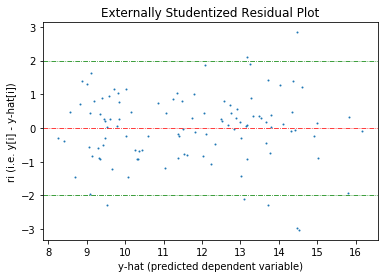

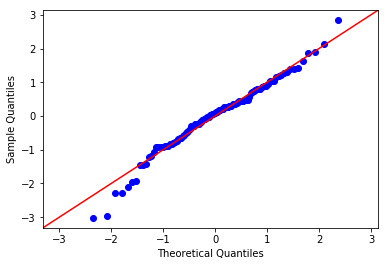

In [319]:
import matplotlib.pyplot as plt
extresid = model.get_influence().resid_studentized_external
pred = model.predict()

plt.scatter(pred, extresid, s = 1)
plt.xlabel('y-hat (predicted dependent variable)')
plt.ylabel('ri (i.e. y[i] - y-hat[i])')
plt.axhline(y=2, color='g', linestyle='-.', linewidth = 0.75)
plt.axhline(y=0, color='r', linestyle='-.', linewidth = 0.75)
plt.axhline(y=-2, color='g', linestyle='-.', linewidth = 0.75)
plt.title('Externally Studentized Residual Plot')
plt.show()

import statsmodels.api as sm
    
sm.qqplot(extresid, line='45')
plt.show()

In [320]:
predicted_values = model.predict(
                    {'intercept': [1, 1],
                     'colorscore': [4, 2],
                     'clarityscore': [6, 4],
                     'cutscore': [4, 3],
                     'cbrt_carat': [0.58**(1/3), 1.03**(1/3)]})

# To do prediction, BCy has to be transformed back to original y.
box_cox_transform_inverse(predicted_values, lambda_fit)

0    2290.564847
1    4599.565833
dtype: float64

## Ridge Regression

In [321]:
df = pd.read_csv('murder-rate.txt', sep = '\s+')

# UR: Per mil (per 10-3) of population living in urban areas
# B: Births per 1, 000
# HT: Death rate from heart disease per 100, 000 residents
# S: Suicide rate per 100, 000
# MA: Marriage rate per 10, 000
# D: Divorce rate per 10, 000
# HS: Per mil high school grads
# CR: Crime rate per 100, 000 population
# PL:Per mil of population below poverty level
# M: Murder rate per 100, 000 population
    
X = df[['UR', 'B', 'HT', 'S', 'MA', 'D', 'HS', 'CR', 'PL']].copy()
y = df['M']

## Checking Multicollinearity

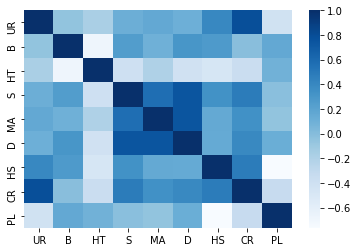

In [322]:
corr = X.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Blues)

In [323]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#X.reset_index(drop=True, inplace=True)

X['constant'] = 1 # add a constant as the intercept
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    print(f'[{X.columns[i]}] vif == {vif:.5f}: ', end = '')
    if vif > 5:
    # to demonstrate the technique, the threshold is set to 5.
        print('multicollinearity is SERIOUS')
    else:
        print('multicollinearity is NOT that serious')

[UR] vif == 4.23223: multicollinearity is NOT that serious
[B] vif == 3.13776: multicollinearity is NOT that serious
[HT] vif == 2.77283: multicollinearity is NOT that serious
[S] vif == 3.21148: multicollinearity is NOT that serious
[MA] vif == 2.50905: multicollinearity is NOT that serious
[D] vif == 4.12930: multicollinearity is NOT that serious
[HS] vif == 5.92195: multicollinearity is SERIOUS
[CR] vif == 6.17075: multicollinearity is SERIOUS
[PL] vif == 4.85648: multicollinearity is NOT that serious
[constant] vif == 769.23894: multicollinearity is SERIOUS


## Linear Regression

Naively fit a linear regression model

In [324]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

rmse = np.average(cross_val_score(estimator=lr, X=X, y=y.values.ravel(), cv=10,
                scoring='neg_root_mean_squared_error', n_jobs=3, verbose=0, error_score='raise')) * -1
print(f'average RMSE: {rmse:.3f}')

average RMSE: 28.349


Fit a linear regression model without CR

In [325]:
rmse = np.average(cross_val_score(estimator=lr, X=X.drop('CR', axis=1), y=y.values.ravel(), cv=10,
                scoring='neg_root_mean_squared_error', n_jobs=3, verbose=0, error_score='raise')) * -1
print(f'average RMSE: {rmse:.3f}')

average RMSE: 26.955


## Ridge Regression with Hyperparameter Tuning

In [326]:
from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 25000, 50000, 100000]

#ridge = Ridge(alpha=0.23427, fit_intercept=False)
#ridge_fit = ridge.fit(X=sm.add_constant(X), y=y.values.ravel())
#rmse = np.average(cross_val_score(estimator=ridge, X=sm.add_constant(X), y=y.values.ravel(), cv=10,
#                scoring='neg_root_mean_squared_error', n_jobs=3, verbose=0, error_score='raise')) * -1
#print(f'average RMSE: {rmse:.3f}')

#ridge = Ridge(alpha=0.23427)
#rmse = np.average(cross_val_score(estimator=ridge, X=X, y=y.values.ravel(), cv=10,
#                scoring='neg_root_mean_squared_error', n_jobs=3, verbose=0, error_score='raise')) * -1
#print(f'average RMSE: {rmse:.3f}')

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    rmse = np.average(cross_val_score(estimator=ridge, X=X, y=y.values.ravel(), cv=10, 
                                      scoring='neg_root_mean_squared_error',
                                      n_jobs=3, verbose=0, error_score='raise')) * -1
    print(f'alpha: {alpha}, average RMSE: {rmse:.3f}')


#mean_squared_error(y_true=y, y_pred=model.predict(X), squared=False)

alpha: 0.01, average RMSE: 28.349
alpha: 0.1, average RMSE: 28.349
alpha: 1, average RMSE: 28.347
alpha: 10, average RMSE: 28.330
alpha: 100, average RMSE: 28.161
alpha: 1000, average RMSE: 26.777
alpha: 10000, average RMSE: 22.579
alpha: 25000, average RMSE: 22.017
alpha: 50000, average RMSE: 22.792
alpha: 100000, average RMSE: 24.965
